### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from neuropy.utils import signal_process
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import subjects
import pandas as pd

### View spectrogram (whitened or regular)

In [ ]:
import numpy as np
import subjects

sessions = subjects.sd.ratUday4

In [ ]:
from neuropy.utils.signal_process import FourierSg
from hfuncs import whiten_signal

for sub,sess in enumerate(sessions):
    signal = sess.eegfile.get_signal(82)
    signal = whiten_signal(signal)
    spect = FourierSg(signal,window=60,overlap=10)

In [ ]:
%matplotlib widget
from neuropy.plotting import plot_signal_heatmap
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.imshow(
    spect.traces,
    aspect="auto",
    vmax=0.004,
    cmap="jet",
    origin="lower",
    extent=[spect.time[0], spect.time[-1], spect.freqs[0], spect.freqs[-1]],
)


In [ ]:
%matplotlib widget
from neuropy.plotting import plot_signal_heatmap
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.imshow(
    spect.traces,
    aspect="auto",
    vmax=0.004,
    cmap="jet",
    origin="lower",
    extent=[spect.time[0], spect.time[-1], spect.freqs[0], spect.freqs[-1]],
)


### Pooled detection hippocampal slow waves 

In [ ]:
sessions = subjects.nsd.pf_sess + subjects.sd.pf_sess

# bottom channels (radiatum channels)
channels = [23,103,183,111,79,79,23,103,183,191,191,127,55]
# channels = [91, 77, 32, 57, 20, 13, 45, 32, 57, 7, 83]

assert len(channels) == len(sessions)

In [ ]:
from tqdm.notebook import tqdm

from neuropy.analyses.oscillations import detect_hpc_slow_wave_epochs

for sub,sess in enumerate(tqdm(sessions)):

    signal = sess.eegfile.get_signal(channels[sub])
    states = sess.brainstates['nrem'].duration_slice(min_dur=60)
    epochs = detect_hpc_slow_wave_epochs(signal,(0.5,4),nrem_epochs=states)
    epochs.save(sess.filePrefix.with_suffix('.sw'))

### Fig1A related:Averaged slow oscillation power during NSD and SD POST

In [8]:
# sessions = subjects.nsd.ratSday2 + subjects.sd.ratSday3
sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [14]:
swa, swa_time, brainstates = [], [], []
for sess in sessions:
    maze= sess.paradigm["maze"].flatten()
    post= sess.paradigm["post"].flatten()
    t_start =maze[0]
    t_stop = t_start + 8*3600
    states =sess.brainstates.time_slice(t_start, t_stop).shift(-t_start)

    signal = sess.eegfile.get_signal(127, t_start=t_start, t_stop=t_stop).rescale(
        0.95 * 1e-3
    )
    spect = signal_process.FourierSg(signal, window=5 * 60, overlap=60, norm_sig=False)
    swa.append(spect.delta)
    swa_time.append(spect.time-t_start)
    brainstates.append(states.to_dataframe())

# subjects.GroupData().save(
#     dict(swa=swa, swa_time=swa_time, brainstates=brainstates), "swa_examples"
# )


150.0
150.0


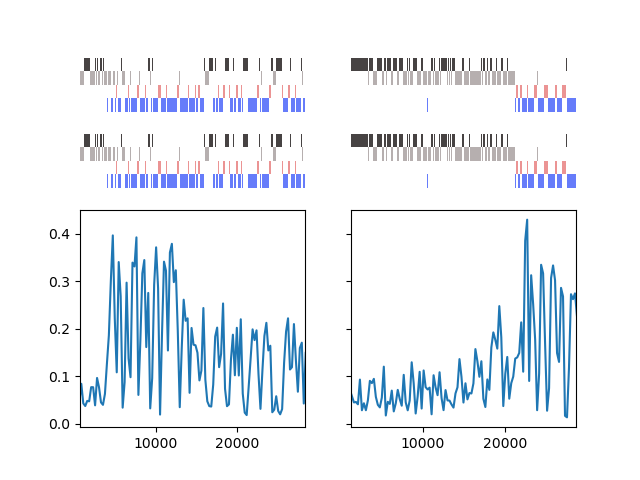

In [15]:
from neuropy.plotting import plot_epochs, plot_hypnogram
from neuropy.core import Epoch

_, axs = plt.subplots(
    3, 2, sharey="row", sharex="col", gridspec_kw=dict(height_ratios=[1, 1, 4])
)

for i in range(2):
    time = swa_time[i]

    plot_hypnogram(
        Epoch(brainstates[i]),
        ax=axs[0, i],
        # labels_order=["nrem", "rem", "quiet", "active"],
        # colors=subjects.colors_sleep_old,
    )

    plot_epochs(
        brainstates[i],
        ax=axs[1, i],
        labels_order=["nrem", "rem", "quiet", "active"],
        colors=subjects.colors_sleep_old,
    )
    axs[1,i].axis('off')

    axs[2, i].plot(time, swa[i])
    # axs[1,i].set_xlim(left=time[0])
    x_ticks = axs[1, i].get_xticks()
    new_xticks = (x_ticks - swa_time[i][0]) / 3600
    # axs[1,i].set_xticks(x_ticks,new_xticks.round(2))
    print(time[0])


In [11]:
5*3600

18000

### Best slow wave channels based on bimodality of slope

In [ ]:
import numpy as np
import subjects

sessions = subjects.sd.ratKday1

In [ ]:
from neuropy.utils.signal_process import FourierSg
from hfuncs import whiten_signal
import scipy.signal as sg
from numpy.polynomial import polynomial
from scipy.ndimage import gaussian_filter1d

for sub, sess in enumerate(sessions):

    # channels = [19,25,2,1,93,87,189,183]
    channels = np.arange(10)
    slopes = []
    for chan in channels:
        signal = sess.eegfile.get_signal(chan)
        # spect = FourierSg(signal,window=60,overlap=10)
        f, t, spect = sg.spectrogram(
            signal.traces[0], fs=1250, nperseg=60 * 1250, noverlap=10 * 1250,axis=-1
        )
        spect = gaussian_filter1d(spect,sigma=4,axis=0)

        indices = (f>4) & (f<90)
        f = np.log10(f[indices])
        spect = np.log10(spect[indices,:])

        invalid_col = ~np.isfinite(spect).any(axis=0)
        linfit = np.polyfit(f,spect[:,~invalid_col],deg=1)
        slopes.append(linfit[0])


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.signal import find_peaks
from dip import diptst
# bins = np.linspace(1,3,100)
_,ax = plt.subplots(1,1)
bins = np.arange(1,3.5,0.02)
metric=[]
for i,slp in enumerate(slopes):
    
    hist_slopes = np.histogram(np.abs(slp),bins=bins)[0]
    # kde = sm.nonparametric.KDEUnivariate(gaussian_filter1d(np.abs(slp),sigma=2))
    # kde.fit()
    hist_slopes = gaussian_filter1d(hist_slopes,sigma=2)
    metric.append(diptst(hist_slopes,is_hist=True)[1])

    # peaks_ind = find_peaks(kde.density)[0]

    # if len(peaks_ind)>1:
    #     peaks_ind = peaks_ind[:2]
    #     peaks_loc = kde.support[peaks_ind]
    #     h1,h2 = kde.density[peaks_ind] 

    #     between_peak = kde.density[peaks_ind[0]:peaks_ind[1]]
    #     dip_ind = find_peaks(-1 * between_peak)[0]+ peaks_ind[0]
    #     dip_loc = kde.support[dip_ind]
    #     dip_height = kde.density[dip_ind]

    #     param1 =  np.abs(h1-h2)/(h1+h2)
    #     param2 = np.diff(peaks_loc)

    #     metric.append([param1,param2])
    #     ax.plot(kde.support,kde.density,label=channels[i])

    # else:

    #     ax.plot(kde.support,kde.density,label=channels[i])
    # if i==1:
    ax.plot(bins[:-1],hist_slopes)
#     ax.axvline(peaks_loc[0])
#     ax.axvline(peaks_loc[1])
#     ax.axvline(dip_loc)

# ax.legend()

In [ ]:
metric1 = np.asarray(metric)
_,ax = plt.subplots()
# plt.plot(metric1[:,0],metric1[:,1],'.')
plt.plot(metric,'.')



In [ ]:
%matplotlib widget
from neuropy.plotting import plot_signal_heatmap
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.imshow(
    spect,
    aspect="auto",
    vmax=400,
    cmap="jet",
    origin="lower",
    extent=[t[0], t[-1], f[0], f[-1]],
)

### CCG between Interneurons and hpc slow waves

In [ ]:
import numpy as np
import subjects

sessions = subjects.sd.pf_sess
# channels = [23,103,183,191,127,55]
channels = [13, 45, 32, 57, 7, 83]


In [ ]:
from neuropy.utils.ccg import correlograms
from neuropy.core import Epoch

ccgs_all = []
avg_sw = []
for sub, sess in enumerate(sessions):
    sw = sess.sw.starts
    sw_id = np.ones(len(sw))
    neurons = sess.neurons.get_neuron_type("inter")

    
    trace = sess.eegfile.get_signal(channels[sub]).traces[0]
    frames = np.concatenate([np.arange(e-500,e+500) for e in (sw*1250).astype('int')])
    avg_sw_sub = np.mean(trace[frames].reshape(len(sw),-1),axis=0,keepdims=True)
    avg_sw.append(np.tile(avg_sw_sub,(neurons.n_neurons,1)))

    def _get_ccg(spikes):
        clus = np.concatenate([sw_id, 2 * np.ones(len(spikes))]).astype('int')
        trains = np.concatenate([sw, spikes])
        sort_ind = np.argsort(trains)
        ccgs = correlograms(
            trains[sort_ind],
            clus[sort_ind],
            bin_size=0.010,
            window_size=0.8,
            sample_rate=30000,
        )
        return ccgs[0,1,:]
    
    ccgs_all.append(np.asarray([_get_ccg(_) for _ in neurons.spiketrains]))

ccgs_all = np.vstack(ccgs_all)
avg_sw = np.vstack(avg_sw)

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats

_,axs= plt.subplots(13,5,sharex=True)
axs= axs.reshape(-1)
t = np.linspace(-405,405,ccgs_all.shape[1]+1)
t2 = np.linspace(-400,400,avg_sw.shape[1])
for i,ax in enumerate(axs):

    ax.stairs(ccgs_all[i]/np.mean(ccgs_all[i]),t,fill=True)
    ax.plot(t2,avg_sw[i]/np.sum(avg_sw[i])+0.5,'r')

### Delta amplitude - Ripple probability scatter plot

In [ ]:
sessions = subjects.pf_sess()

In [ ]:
from hfuncs import get_ccg

delta_rpl_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()

    if sess.tag == "NSD":
        period = [post[0], post[0] + 2 * 3600]

    if sess.tag == "SD":
        period = [post[0] + 5 * 3600, post[0] + 7 * 3600]

    if sess.sw is not None:

        sw = sess.sw.time_slice(*period)
        rpls = sess.ripple.time_slice(*period)

        peak_amp = sw.to_dataframe().peakamp
        end_amp = sw.to_dataframe().endamp
        delta_amp = np.abs(peak_amp) + np.abs(end_amp)

        sw_t = sw.to_dataframe().peaktime
        rpl_t = rpls.to_dataframe().peak_time

        quantiles = pd.qcut(delta_amp, q=5, labels=False)

        for q in range(5):

            idx = (quantiles == q).values
            n_delta = np.count_nonzero(idx)
            t, ccg = get_ccg(sw_t[idx], rpl_t, 0.001, 0.8)

            prob = ccg[(t > -0.1) & (t < 0.1)].sum() / n_delta
            mean_amp = np.mean(delta_amp[idx])

            df = pd.DataFrame(
                dict(delta_amp=[mean_amp], prob=[prob], grp=sess.tag, session=sub)
            )
            delta_rpl_df.append(df)

delta_rpl_df = pd.concat(delta_rpl_df, ignore_index=True)


In [ ]:
# _,ax = plt.subplots()
# sns.lineplot(data=delta_rpl_df,x='time',y='prob',hue='grp',ci='sd',ax=ax)

sns.lmplot(
    data=delta_rpl_df,
    x="delta_amp",
    y="prob",
    hue="grp",
    palette=subjects.colors_sd(1.2),
    ci=None,
)
# sns.boxplot(data=delta_rpl_df,x='delta_amp',y='prob',hue='grp',ax=ax)
# ax.axvline(0,color='k')


### Delta - Ripple probability SD vs NSD (histogram)

In [ ]:
sessions = subjects.pf_sess()

In [ ]:
from hfuncs import get_ccg

delta_rpl_df = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()

    if sess.tag == "NSD":
        period = [post[0], post[0] + 2 * 3600]

    if sess.tag == "SD":
        period = [post[0] + 5 * 3600, post[0] + 7 * 3600]

    if sess.sw is not None:

        sw = sess.sw.time_slice(*period)
        rpls = sess.ripple.time_slice(*period)

        peak_amp = sw.to_dataframe().peakamp
        end_amp = sw.to_dataframe().endamp
        delta_amp = np.abs(peak_amp) + np.abs(end_amp)

        sw_t = sw.to_dataframe().peaktime
        rpl_t = rpls.to_dataframe().peak_time

        t, ccg = get_ccg(sw_t, rpl_t, 0.001, 0.8)
        ccg = gaussian_filter1d(ccg,sigma=2)

        df = pd.DataFrame(dict(time=t, prob=ccg/len(sw_t), grp=sess.tag, session=sub))

        delta_rpl_df.append(df)

delta_rpl_df = pd.concat(delta_rpl_df, ignore_index=True)


In [ ]:
fig = plotting.Fig(grid=(5,3))

ax = fig.subplot(fig.gs[1])
sns.lineplot(data=delta_rpl_df,x='time',y='prob',ci='sd',ax=ax,color='#e000d9')
ax.axvline(0,color='k')
# ax.axvline(-0.1,color='r',ls='--')
# ax.axvline(0.1,color='r',ls='--')
ax.axvspan(-0.1,0.1,color='#d0cdcd',alpha=0.3)


# sns.boxplot(data=delta_rpl_df,x='delta_amp',y='prob',hue='grp',ax=ax)
